In [1]:
import dill
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.patches as mpatches
import matplotlib as mpl
from pandas.plotting import parallel_coordinates, andrews_curves
# mpl.use("pgf")
# plt.rcParams['pgf.texsystem'] = 'pdflatex'
# plt.rcParams['text.usetex'] = True
# plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['figure.edgecolor'] = 'k'
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.family'] = "serif"

from mycolorpy import colorlist as mcp
from shapely.geometry import Point

In [2]:
sim_path = "../2023-dotson-prelim/data/2022-12-31-USNGA3-results.pkl"
sim_path = "../../osier_data/2022-12-31-USNGA3-results.pkl"
with open(sim_path, "rb+") as file:
    data = dill.load(file)

In [3]:
F = data.F
X = data.X
# display(X,F)

In [4]:
df = pd.DataFrame({"Cost":F[:,0], "Carbon":F[:,1]})
slack = 1.1
f1 = F[:,0]*slack
f2 = F[:,1]*slack
df2 = pd.DataFrame({"Cost":f1, "Carbon":f2})
df.sort_values(by="Cost", inplace=True)
df2.sort_values(by="Cost", inplace=True)

In [5]:
a = list(zip(F[:,0],F[:,1]))

In [6]:
b = list(zip(f1,f2))

In [7]:
ab = np.concatenate([a,b],axis=0)

In [8]:
ab = list(zip(np.append(df.sort_values(by="Cost").Cost.values, df2.sort_values(by="Cost").Cost.values[::-1]),
np.append(df.sort_values(by="Cost").Carbon.values, df2.sort_values(by="Cost").Carbon.values[::-1])))

In [9]:
# points = list(ab[ab[:,1].argsort()])
points = list(ab)

In [10]:
from shapely import geometry
from shapely.geometry import Point, Polygon

In [11]:
poly = Polygon(points)

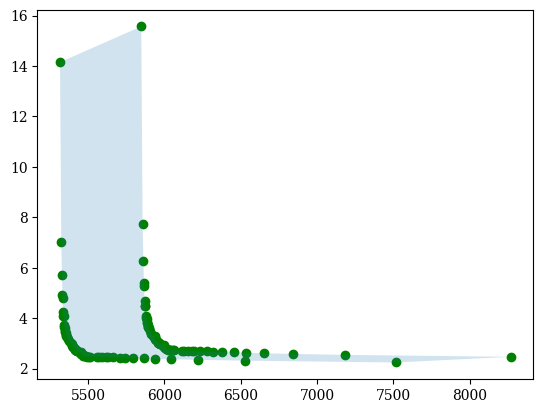

In [12]:
fig, ax = plt.subplots()
ax.scatter(*zip(*points), c='green')
ax.fill(np.append(df.sort_values(by="Cost").Cost.values, df2.sort_values(by="Cost").Cost.values[::-1]),
np.append(df.sort_values(by="Cost").Carbon.values, df2.sort_values(by="Cost").Carbon.values[::-1]), alpha=0.2)

In [31]:
import time

[ 8268.691744829568 15.568493424764664 ]
Time: 2.88 seconds


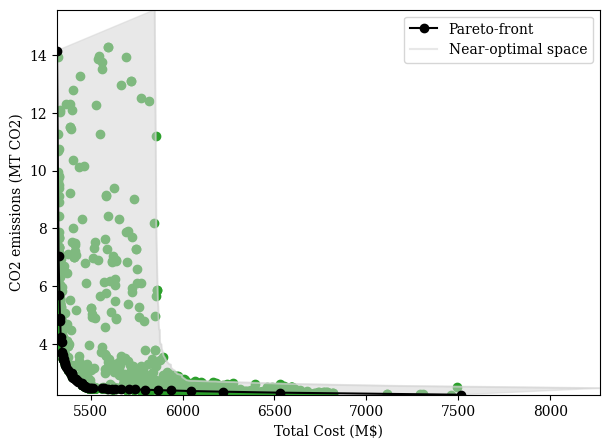

In [43]:
color_1 = 'k'
color_2 = 'lightgrey'
alpha = 0.5

F1_sub = []
F2_sub = []
X_sub = []
checked_points = set()
plotted_points = set()
print("[",f1.max(), f2.max(),"]")
fig, ax = plt.subplots(figsize=(7,5), facecolor='w')
color_list = mcp.gen_color('jet', n=len(data.history))

start = time.perf_counter()
for i,(h,c) in enumerate(zip(data.history, color_list)):
    F_hist = h.pop.get("F")
    X_hist = h.pop.get("X")
    F_hist_masked = np.ma.masked_values(F_hist, 1e40)
#     if i%100==0:
#         ax.scatter(F_hist_masked[:, 0], F_hist_masked[:, 1], s=10, facecolors='none', 
#                     edgecolors='blue', alpha=0.1)
    
    for x,y,z in zip(F_hist[:,0], F_hist[:,1], X_hist):
        if (x,y) in checked_points:
            continue
        else: 
            if poly.contains(Point(x,y)):
                ax.scatter(x,y,color='tab:green')
                F1_sub.append(x)
                F2_sub.append(y)
                X_sub.append(z)
                checked_points.add((x,y))
            
end = time.perf_counter()
print(f"Time: {end-start:.2f} seconds")

df.sort_values(by="Cost").plot.line(ax=ax,x='Cost', y='Carbon',legend=False, color=color_1, marker='o', 
                                    label='Pareto-front')
df2.sort_values(by="Cost").plot.line(ax=ax,x='Cost', y='Carbon',legend=False, color=color_2, alpha=alpha,
                                    label='Near-optimal space')

patch = ax.fill(np.append(df.sort_values(by="Cost").Cost.values, df2.sort_values(by="Cost").Cost.values[::-1]),
       np.append(df.sort_values(by="Cost").Carbon.values, df2.sort_values(by="Cost").Carbon.values[::-1]),
       alpha=alpha, color=color_2)

ax.set_xlim(min(F[:,0]),max(F[:,0])*slack)
ax.set_ylim(min(F[:,1]),max(F[:,1])*slack)

plt.xlabel("Total Cost (M$)")
plt.ylabel("CO2 emissions (MT CO2)")
plt.legend()
plt.show()

In [45]:
subopt_df = pd.DataFrame({'Cost':F1_sub, 'Carbon':F2_sub, 'Designs':X_sub})
subopt_df.head()

,Cost,Carbon,Designs
0,5862.559637,5.879759,"[0.6285264702450225, 0.04825692340121242, 0.06..."
1,6100.994873,2.671806,"[0.6327077774633276, 0.07693995812472318, 0.0,..."
2,5916.958743,3.027023,"[0.5447908109793637, 0.04588218237900135, 0.0,..."
3,5862.559637,5.879759,"[0.6285264702450226, 0.04825692340121242, 0.06..."
4,6141.998341,2.568306,"[0.6427802007253219, 0.07816480765494292, 0.0,..."


[ 8268.691744829568 15.568493424764664 ]


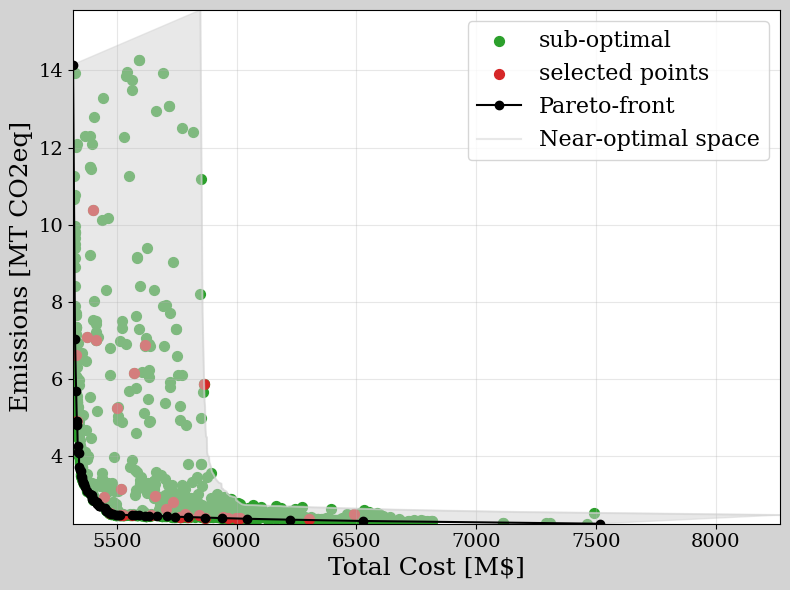

In [48]:
color_1 = 'k'
color_2 = 'lightgrey'
alpha = 0.5
N_solutions = 31
np.random.seed(1234)

F1_sub = []
F2_sub = []
print("[",f1.max(), f2.max(),"]")
fig, ax = plt.subplots(figsize=(8,6), facecolor='lightgray')
color_list = mcp.gen_color('jet', n=len(data.history))

labeled = True
for i,(h,c) in enumerate(zip(data.history, color_list)):
    
#     if (i < 5) or (i > 12):
    if i > 2000:
        continue
    else:
        F_hist = h.pop.get("F")
        X_hist = h.pop.get("X")
        F_hist_masked = np.ma.masked_values(F_hist, 1e40)

subopt_df.plot.scatter(ax=ax, x='Cost', y='Carbon', legend=True, 
                       color='tab:green', marker='o', label='sub-optimal',s=50)

X_select = np.zeros((10,N_solutions)).T
for n in range(N_solutions):
    loc = np.random.randint(len(subopt_df))
    if n == 0:
        subopt_df.loc[[loc]].plot.scatter(ax=ax, x='Cost', y='Carbon', s=50,
                                          color='tab:red', marker='o', label='selected points')
    else:
        subopt_df.loc[[loc]].plot.scatter(ax=ax, x='Cost', y='Carbon', legend=False,s=50,
                                          color='tab:red', marker='o', label='sub-optimal')
    
    X_select[n] = subopt_df.loc[loc, 'Designs']

df.sort_values(by="Cost").plot.line(ax=ax,x='Cost', y='Carbon',legend=False, color=color_1, marker='o', 
                                    label='Pareto-front', markersize=6)
df2.sort_values(by="Cost").plot.line(ax=ax,x='Cost', y='Carbon',legend=False, color=color_2, alpha=alpha,
                                    label='Near-optimal space')

patch = ax.fill(np.append(df.sort_values(by="Cost").Cost.values, df2.sort_values(by="Cost").Cost.values[::-1]),
       np.append(df.sort_values(by="Cost").Carbon.values, df2.sort_values(by="Cost").Carbon.values[::-1]),
       alpha=alpha, color=color_2)

ax.set_xlim(min(F[:,0]),max(F[:,0])*slack)
ax.set_ylim(min(F[:,1]),max(F[:,1])*slack)
ax.grid(alpha=0.3)

plt.xlabel("Total Cost [M\$]", fontsize=18)
plt.ylabel("Emissions [MT CO2eq]", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc='upper right')
plt.tight_layout()
# plt.savefig("../2023-dotson-prelim/docs/figures/osier_mga_subset_01.png")
# plt.savefig("../docs/figures/osier_mga_subset_01.pgf")
plt.show()

In [50]:
with open('../data/2022-12-31-optimal_objective_F.pkl', "rb") as file:
    osier_F = dill.load(file)
with open('../data/2022-12-31-optimal_design_X.pkl', "rb") as file:
    osier_X = dill.load(file)
with open('../data/2022-11-18-temoa_mga_objective.pkl', "rb") as file:
    temoa_F = dill.load(file)
with open('../data/2022-11-18-temoa-mga-design.pkl', "rb") as file:
    temoa_X = dill.load(file)
with open('../data/2022-12-31-techset.pkl', "rb") as file:
    techs = dill.load(file)

labels = [t.technology_name for t in techs]

In [51]:
peak_demand = 29.251353638620195

In [52]:
X_select.shape

(31, 10)

In [53]:
hex_colors = []
for c in plt.cm.tab10.colors:
    hex_colors.append(mpl.colors.to_hex(c))

In [58]:
len(df)

60

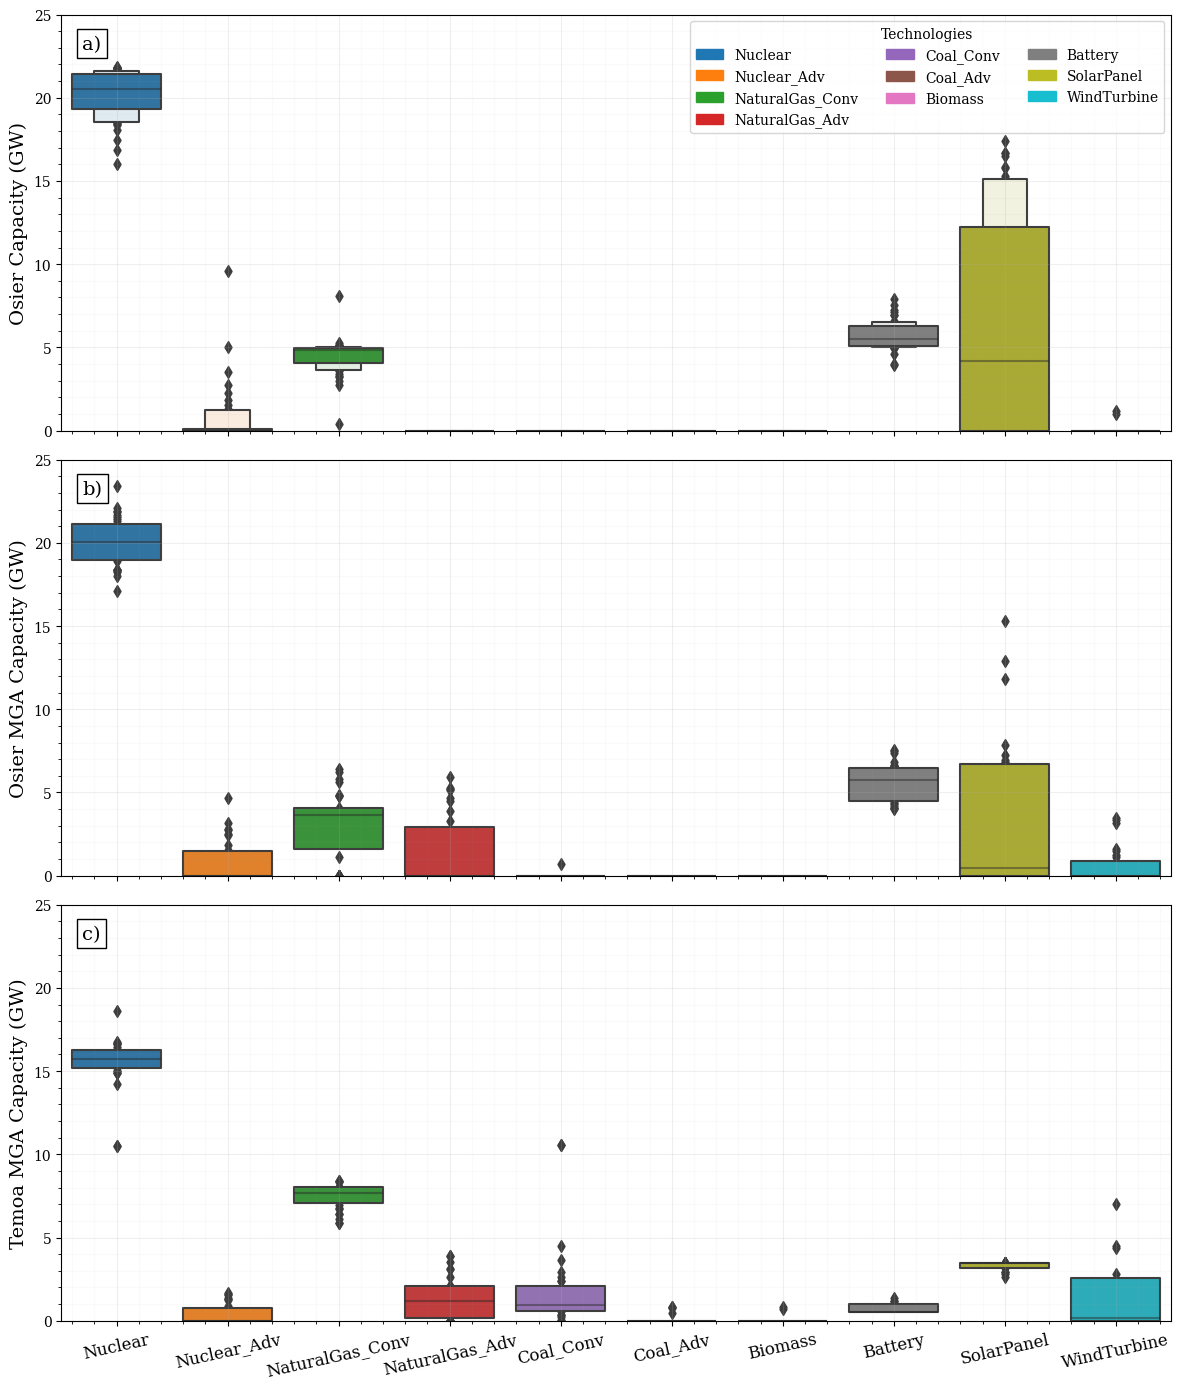

In [54]:
fig, axes = plt.subplots(3,1,figsize=(12,14), facecolor='w', sharex=True, sharey=True)
sb.boxenplot(ax=axes[0], data=(osier_X)*peak_demand)
sb.boxenplot(ax=axes[1], data=(X_select)*peak_demand)
sb.boxenplot(ax=axes[2], data=(temoa_X))
# axes[0].scatter(labels, osier_cost_opt, color='k')
# axes[1].scatter(labels, temoa_cost_opt, color='k')
axes[0].minorticks_on()
axes[1].minorticks_on()
axes[2].minorticks_on()
axes[0].set_ylabel('Osier Capacity (GW)', size=14)
axes[1].set_ylabel('Osier MGA Capacity (GW)', size=14)
axes[2].set_ylabel('Temoa MGA Capacity (GW)', size=14)
# axes[1].set_ylim(0, 30)
axes[0].grid(alpha=0.2, which='major')
axes[0].grid(alpha=0.05, which='minor')
axes[1].grid(alpha=0.2, which='major')
axes[2].grid(alpha=0.2, which='major')
axes[1].grid(alpha=0.05, which='minor')
axes[2].grid(alpha=0.05, which='minor')
axes[0].set_ylim(0,25)
axes[1].set_ylim(0,25)
axes[2].set_ylim(0,25)


# sb.barplot(ax=axes[2], data=opt_df, x='Techs', y='Capacity', hue='Objective', palette='Paired')
# sb.barplot(ax=ax, x=labels, y=temoa_cost_opt)
# sb.barplot(ax=ax, x=labels, y=osier_cost_opt)
axes[2].set_xticklabels(labels, rotation=12.5, size=12)
axes[2].set_xticks(range(len(labels)))
# axes[2].set_ylabel("Capacity (GW)", size=14)
axes[2].set_xlabel("", size=14)

x_loc, y_loc = -.31, 22.95
axes[0].text(x_loc,y_loc, "a)", fontsize=14, bbox=dict({'facecolor':'w'}))
axes[1].text(x_loc,y_loc, "b)", fontsize=14, bbox=dict({'facecolor':'w'}))
axes[2].text(x_loc,y_loc, "c)", fontsize=14, bbox=dict({'facecolor':'w'}))

patch = mpatches.Patch(color='grey', label='manual patch')
patches = []
for color, label in zip(hex_colors, labels):
    patches.append(mpatches.Patch(color=color, label=label))

handles, llabels = axes[0].get_legend_handles_labels()
handles.extend(patches)
# print(handles, llabels)

axes[0].legend(handles=handles, ncol=3, title='Technologies')
# axes[1].legend(handles=handles, ncol=4)
# axes[2].legend(ncol=3, title='Objectives')

plt.tight_layout()


# plt.savefig("../2023-dotson-prelim/docs/figures/temoa_osier_mga_comparison1x3.pgf")

plt.show()

In [67]:
labels

['Nuclear',
 'Nuclear_Adv',
 'NaturalGas_Conv',
 'NaturalGas_Adv',
 'Coal_Conv',
 'Coal_Adv',
 'Biomass',
 'Battery',
 'SolarPanel',
 'WindTurbine']

In [174]:
osier_tech_df = pd.DataFrame(dict(zip(labels,X.T)))
osier_tech_df['Class'] = ['Osier: Pareto Front']*len(F)

In [175]:
osier_mga_tech_df = pd.DataFrame(dict(zip(labels,np.hstack(subopt_df.Designs.values).reshape(len(subopt_df),10).T)))
osier_mga_tech_df['Class'] = ['Osier: MGA']*len(subopt_df)

In [176]:
temoa_tech_df = pd.DataFrame(dict(zip(labels,temoa_X.T/peak_demand)))
temoa_tech_df['Class'] = ['Temoa: MGA']*len(temoa_X)

In [181]:
frames = [osier_mga_tech_df, osier_tech_df, temoa_tech_df]
combined = pd.concat(frames, axis=0).reset_index(drop=True)

In [182]:
max_vals = combined.iloc[:,:-1].max(axis=0).values
min_vals = combined.iloc[:,:-1].min(axis=0).values

In [183]:
# combined.iloc[:,:-1]=combined.iloc[:,:-1].divide(combined.iloc[:,:-1].max(axis=0),axis=1)

In [192]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

In [198]:
max_vals.round(2)

array([0.87, 0.33, 0.29, 0.27, 0.36, 0.03, 0.06, 0.44, 0.59, 0.37])

In [203]:
np.linspace(0,1,11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

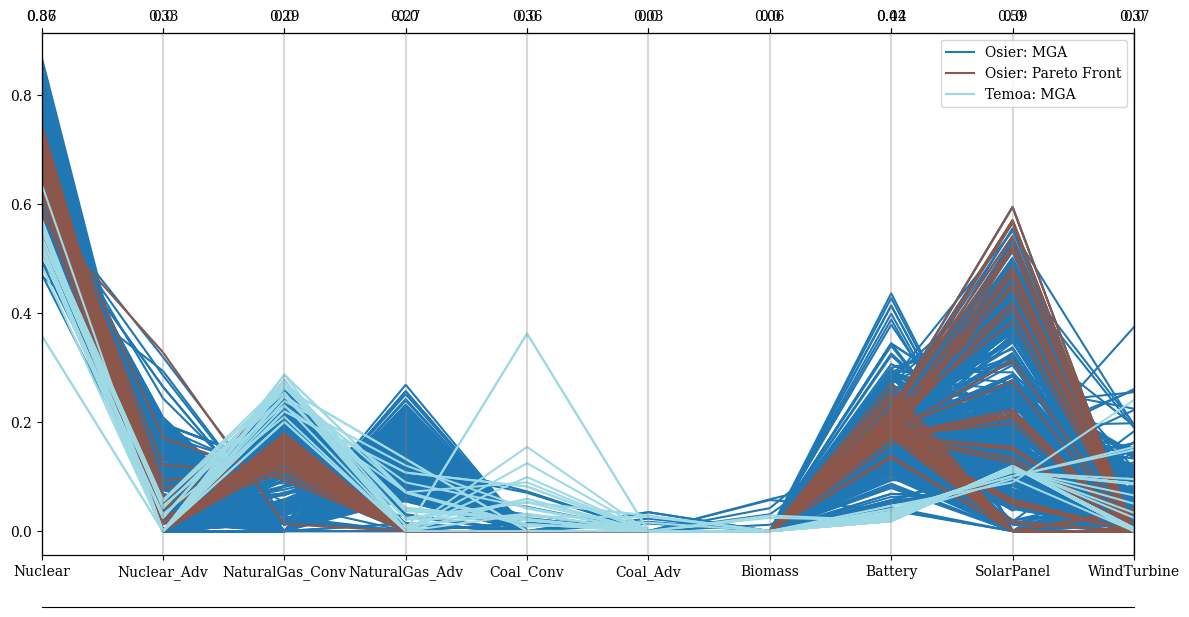

In [230]:
fig, ax = plt.subplots(figsize=(12,6), facecolor='w', edgecolor='k')
parallel_coordinates(combined,'Class',
                     ax=ax, 
                     axvlines=True, 
                     axvlines_kwds={'color':'grey', 'alpha':0.3, 
                                    'marker':'P','markevery':None, 'markersize':0,'markerfacecolor':'red'},
                     colormap='tab20')
# ax.set_xticklabels(labels, rotation=20)
ax.grid(False)
# ax.set_ylim(0,1)
# ax.set_yticklabels([])
# ax.set_xticklabels(min_vals)
locations = np.linspace(0,1,10)
max_ax = ax.twiny() 
max_ax.spines['top'].set_position(("axes",1.))
max_ax.spines['top'].set_visible(True)
max_ax.set_xticks(ticks=locations, labels=max_vals.round(2))
# max_ax.set_xticklabels(max_vals.round(2))

# ax.spines['bottom'].set_position(("axes",0.1))
# ax.spines['bottom'].set_visible(False)
# ax.tick_params(axis='both', bottom=False)


min_ax = ax.twiny()
min_ax.spines['bottom'].set_position(("axes",-.1))
# make_patch_spines_invisible(min_ax)
# min_ax.spines['bottom'].set_visible(True)
min_ax.set_xticks(ticks=locations, labels=min_vals.round(2))

# ax.set_xticks(ticks=locations, labels=min_vals.round(2))


plt.tight_layout()
plt.show()